# Lab 5: Build agentic conversational search



In this notebook, you will build a "shopping assistant" chat bot using OpenSearch Service out-of-the-box ML features. You will start by installing the relevant librairies and dependecies. Then you will create a python client to connect to OpenSearch Service and AWS resources. Afterwards, you will create the necessary components to build a multimodal conversational such as OpenSearch KNN index, OpenSearch search pipeline with RAG processor.

The content from step 1 to step 5 is related to building the multimodal RAG using multimodal embeddings for both text and images. 

Step 6 of the notebook is a pre-requisite to the second part of the lab where you will augment the conversational search with an AI agent. Once you finish step 6, you can get back to the workshop and follow the steps to experiment with agentic RAG on the web application deployed in the beginning of the workshop.

<H2>Part 1: Build multimodal conversational search with OpenSearch Service</H2>

The vector dataset used in this part of the lab is comprised of \a variety of products that have been sold on Amazon.com  
You will use OpenSearch ingest pipeline with embedding processor to generate multimodal embeddings for both text and images from the dataset. Using the neural plugin in OpenSearch will allow you to generate the embeddings of the search query as well.
You will then use the Anthropic Claude v2 large language model (LLM) with the RAG processor in the search pipeline to generate text. The RAG processor will combine the retrieved search results from OpenSearch with the generated answer from the LLM to send back to the end user.

Follow step 1 to step 5 to complete part 1 of the lab.

### The key steps in part 1 of this lab are as follow:

1. Get pre-requisites installed and libraries imported.
1. Download the sample data set from S3 (items.txt), create a KNN-enabled index and ingest the catalog items into the index.
1. Find connectors and register the various ML models we will be using (multimodal embedding model, large language model).
1. Deploy the search pipeline.
1. Test conversational search.
1. Export the model IDs deployed in this notebook for use in the web application.

# 1. Lab Pre-requisites
This notebook is designed to be run as part of the larger workshop [Build next-gen search with Amazon OpenSearch Service](https://catalog.workshops.aws/opensearch-ml-search/en-US]).
Before proceeding with this notebook, you should complete all of the [setup steps](https://catalog.workshops.aws/opensearch-ml-search/en-US/setup/deploy-app).

## 1.1. Import libraries & initialize resources
The code blocks below will install and import all the relevant libraries and modules used in this notebook.

In [ ]:
!pip install opensearch-py -q
!pip install opensearch_py_ml -q
!pip install deprecated -q
!pip install requests_aws4auth -q
!pip install streamlit -q

print("Installs completed.")

Import the required libraries:

In [ ]:
# Import Python libraries
import boto3
import json
from opensearchpy import OpenSearch, RequestsHttpConnection
import os
from os import path
import urllib.request
import tarfile
from requests_aws4auth import AWS4Auth
from ruamel.yaml import YAML
from PIL import Image
import base64
import re
import time as t
import pandas as pd
from IPython.display import display, HTML
import sys
import requests
sys.path.append('/home/ec2-user/SageMaker/AI-search-with-amazon-opensearch-service/OpenSearchApp/semantic_search')
import dynamo_state as ds
print("Imports and initialization completed.")

# 2. Download and index the sample data set (product catalog)

We have taken the esci dataset and prepared it as follows:
- Downloaded product images
- Used multimodal embedding model to create separate vector embeddings for each product title and image
- Wrote the product details and vector embeddings back into a dictionary object
- Wrote it out to data_esci_index.txt

The following cells will download the .txt file and walk through ingesting all 56,487 products into our OpenSearch KNN index.

In [ ]:
# Download and extract the data_esci_index.txt file from the workshop S3 bucket

!aws s3 cp s3://ws-assets-prod-iad-r-pdx-f3b3f9f1a7d6a3d0/e35b177d-47a5-4276-8584-dc5cf96ca8e6/data_esci_index.txt.zip /home/ec2-user/SageMaker/data_esci_index.txt.zip
!cd /home/ec2-user/SageMaker && unzip -o data_esci_index.txt.zip
print("Files downloaded and unzipped.")

## 2.2 Establish a connection to the OpenSearch Service domain



In [ ]:
# Get the Amazon OpenSearch Service domain endpoint info from DynamoDB
session = boto3.Session()
account_id = boto3.client('sts').get_caller_identity().get('Account')
region = session.region_name

aos_host = ds.get_from_dynamo("OpenSearchDomainEndpoint")
aos_host

### 🚨 Authentication cell below 🚨 
The below cell establishes an authenticated connection to our OpenSearch Service domain. The connection will periodically expire.
If you see an `AuthorizationException` error later in this notebook it means that the connection has expired and you just need to re-run the cell to get a new security tokken.

In [102]:
# Connect to OpenSearch using the IAM Role of this notebook
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(
    credentials.access_key,
    credentials.secret_key,
    region,
    'es',
    session_token=credentials.token
)

# Create OpenSearch client
aos_client = OpenSearch(
    hosts=[f'https://{aos_host}'],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    timeout=60
)
print("Connection details: ")
aos_client

Connection details: 


<OpenSearch([{'host': 'search-opensearchservi-6vvwmerkz2qq-wauita5w3ffcalgmd44hed5keu.us-west-2.es.amazonaws.com', 'port': 443, 'use_ssl': True}])>

## 2.3 Create the index with defined mappings.

It is important to define the 'knn_vector' fields as without the propper definitions dynamic mapping would type these as simple float fields.


In [ ]:
### Create the k-NN index
# Check if the index exists. Delete and recreate if it does. 
if aos_client.indices.exists(index='opensearch-rag-index'):
    print("The index exists. Deleting...")
    response = aos_client.indices.delete(index='opensearch-rag-index')
    
payload = { 
  "settings": {
    "index": {
      "knn": True
    }
  },
    "mappings": {
          "properties": {
            "asin": {
              "type": "keyword"
            },
            "formats": {
              "type": "object"
            },
            "image": {
              "type": "keyword"
            },
            "info": {
              "type": "object"
            },
            "locale": {
              "type": "keyword"
            },
            "price": {
              "type": "double"
            },
            "product_image": {
              "type": "binary"
            },
            "product_multimodal_vector": {
              "type": "knn_vector",
              "dimension": 1024,
              "method": {
                "engine": "faiss",
                "space_type": "l2",
                "name": "hnsw",
                "parameters": {}
              }
            },
            "product_title_vector": {
              "type": "knn_vector",
              "dimension": 1024,
              "method": {
                "engine": "faiss",
                "space_type": "l2",
                "name": "hnsw",
                "parameters": {}
              }
            },
            "template": {
              "type": "keyword"
            }
          }
        }
}

print("Creating index...")
response = aos_client.indices.create(index='opensearch-rag-index',body=payload)
response

## 2.4 Load data into the new index

The data_esci_index.txt file contains 56,487 products in JSON format. Each product has all of the fields listed in the index definition from the previous cell. 

We will use the [bulk API](https://opensearch.org/docs/latest/api-reference/document-apis/bulk/) to load all of the products into our newly created index. 

In [95]:
## Index TEXT file into index: opensearch-rag-index
batch = 0
count = 0
batch_size = 75
body_ = ''
action = json.dumps({ 'index': { '_index': 'opensearch-rag-index' } })
errors = []
with open('/home/ec2-user/SageMaker/data_esci_index.txt', 'r') as file:
    for line in file:
        if count > 75000:
            break # Use this to run a limited number of items.
        if '$' in line:
            line = json.loads(line)
            if '$' in line['price']:
                line['price'] = line['price'].replace('$', '') #remove $ from price field
                line['price'] = line['price'].replace(',', '') #remove $ from price field
            line = json.dumps(line)
        body_ = body_ + action + "\n" + line + "\n"
        if count % batch_size == 0 and count != 0:
            batch+=1
            if count % (batch_size*30) == 0:
                print("Batch: " + str(batch) + ", count: " + str(count)+ ", errors: " + str(len(errors)))
            response = aos_client.bulk(
                index = 'opensearch-rag-index',
                body = body_
            )
            body_ = ''
            if response['errors'] == True:
                for item in response['items']:
                    if item['index']['status'] != 201:
                        errors.append(item['index']['error']) 
        count += 1
response = aos_client.bulk(
    index = 'opensearch-rag-index',
    body = body_
)
if response['errors'] == True:
    for item in response['items']:
        if item['index']['status'] != 201:
            errors.append(item['index']['error'])
print("Last batch: " + str(batch) + ", documet count: " + str(count)+ ", errors: " + str(len(errors)))

Batch: 30, count: 2250, errors: 0
Batch: 60, count: 4500, errors: 0
Batch: 90, count: 6750, errors: 0
Batch: 120, count: 9000, errors: 0
Batch: 150, count: 11250, errors: 0
Batch: 180, count: 13500, errors: 0
Batch: 210, count: 15750, errors: 0
Batch: 240, count: 18000, errors: 0
Batch: 270, count: 20250, errors: 0
Batch: 300, count: 22500, errors: 0
Batch: 330, count: 24750, errors: 0
Batch: 360, count: 27000, errors: 0
Batch: 390, count: 29250, errors: 0
Batch: 420, count: 31500, errors: 0
Batch: 450, count: 33750, errors: 0
Batch: 480, count: 36000, errors: 0
Batch: 510, count: 38250, errors: 0
Batch: 540, count: 40500, errors: 0
Batch: 570, count: 42750, errors: 0
Batch: 600, count: 45000, errors: 0
Batch: 630, count: 47250, errors: 0
Batch: 660, count: 49500, errors: 0
Batch: 690, count: 51750, errors: 0
Batch: 720, count: 54000, errors: 0
Batch: 750, count: 56250, errors: 0
Last batch: 753, documet count: 56487, errors: 0


# 3. Find connectors and register ML models

As part of the workshop setup, we deployed connectors for multiple different machine models hosted in Amazon Bedrock.
In this step, we will register and deploy models using these connectors. 

## 3.1 Check DynamoDB tables for existing connector and model IDs
If there is no entry for a given connector, then we will simply store the an empty string. 
The following cells will register models as needed based on the retrieved values. Since the multimodal and text embedding connetors are deployed during setup, we can skip creating these. However, the LLM connector has most likely not been created at this stage in the lab, so we will include a cell to create it before registering the LLM model.

_<b>Optional</b>: The complete code of the 'get_from_dynamo' and 'store_in_dynamo' functions can be found in the file: 'AI-search-with-amazon-opensearch-service/OpenSearchApp/semantic_search/dynamo_state.py'_

In [ ]:
# Check DynamoDB table for existing connector and model IDs. 
mm_embedding_connector_id = ds.get_from_dynamo("BEDROCK_MULTIMODAL_CONNNECTOR_ID")
mm_embedding_model_id = ds.get_from_dynamo("BEDROCK_MULTIMODAL_MODEL_ID")

text_embedding_connector_id = ds.get_from_dynamo("BEDROCK_TEXT_CONNNECTOR_ID")
text_embedding_model_id = ds.get_from_dynamo("BEDROCK_TEXT_MODEL_ID")

llm_claude_connector_id = ds.get_from_dynamo("CLAUDE2_LLM_CONNECTOR_ID")
llm_claude_model_id = ds.get_from_dynamo("CLAUDE2_LLM_MODEL_ID")

## 3.2 Register and deploy the embedding models and LLM hosted in Amazon Bedrock

In [ ]:
# Register the multimodal embedding model
if not mm_embedding_model_id:
    # Prepare the payload
    payload = {
        "name": "Bedrock Titan mm embeddings model",
        "function_name": "remote",
        "description": "Bedrock Titan mm embeddings model",
        "connector_id": mm_embedding_connector_id
    }
    # Make the request
    response = aos_client.transport.perform_request(
        'POST',
        '/_plugins/_ml/models/_register',
        body=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )
    mm_embedding_model_id = response['model_id']
    ds.store_in_dynamo("BEDROCK_MULTIMODAL_MODEL_ID",mm_embedding_model_id)
else:
    print("Skipping model registration - model already exists")
print("Multimodal embedding model registered with model_id: " + mm_embedding_model_id)

In [ ]:
# Register the text embedding model
if not text_embedding_model_id:
    # Prepare the payload
    payload = {
        "name": "Bedrock Titan mm embeddings model",
        "function_name": "remote",
        "description": "Bedrock Titan mm embeddings model",
        "connector_id": text_embedding_connector_id
    }
    # Make the request
    response = aos_client.transport.perform_request(
        'POST',
        '/_plugins/_ml/models/_register',
        body=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )
    text_embedding_model_id = response['model_id']
    ds.store_in_dynamo("BEDROCK_TEXT_MODEL_ID",text_embedding_model_id)
else:
    print("Skipping model registration - model already exists")
print("Text embedding model registered with model_id: " + text_embedding_model_id)

Now create an [ML connector](https://docs.aws.amazon.com/opensearch-service/latest/developerguide/ml-amazon-connector.html) in OpenSearch to invoke Claude v2 LLM within OpenSearch RAG processor.

In [ ]:
## Create LLM connector to Anthropic Claude v2
if not llm_claude_connector_id:
    connector_payload = {
        "name": "Amazon Bedrock",
        "description": "Test connector for Amazon Bedrock",
        "version": 1,
        "protocol": "aws_sigv4",
        "credential": {
            "roleArn": f"arn:aws:iam::{account_id}:role/opensearch-sagemaker-role"
        },
        "parameters": {
            "region": "us-west-2",
            "service_name": "bedrock",
            "auth": "Sig_V4",
            "model": "anthropic.claude-v2"
        },
        "actions": [
            {
                "action_type": "predict",
                "method": "POST",
                "headers": {
                    "content-type": "application/json"
                },
                "url": "https://bedrock-runtime.${parameters.region}.amazonaws.com/model/${parameters.model}/invoke",
                "request_body": "{\"prompt\":\"\\n\\nHuman: ${parameters.inputs}\\n\\nAssistant:\",\"max_tokens_to_sample\":300,\"temperature\":0.0,\"top_k\":250,\"top_p\":1,\"stop_sequences\":[\"\\\\n\\\\nHuman:\"]}"
            }
        ]
    }
    
    # Create the connector
    response = aos_client.transport.perform_request(
        'POST',
        '/_plugins/_ml/connectors/_create',
        body=connector_payload
    )
    # Print the response
    llm_claude_connector_id = response['connector_id']
    ds.store_in_dynamo("CLAUDE2_LLM_CONNECTOR_ID",llm_claude_connector_id)
else:
    print("Connector already exists")
    
print("LLM connector ID: " + llm_claude_connector_id)

Register and deploy Claude v2 model in OpenSearch Service

In [ ]:
# Register and deploy the llm model
if not llm_claude_model_id:
    payload = { 
        "name": "Amazon Bedrock Connector: Claude v2",
        "function_name": "remote",
        "description": "The connector to bedrock Claude v2",
        "connector_id": llm_claude_connector_id
    }
    # Make the request
    response = aos_client.transport.perform_request(
        'POST',
        '/_plugins/_ml/models/_register',
        body=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )
    llm_claude_model_id = response['model_id']
    ds.store_in_dynamo("CLAUDE2_LLM_MODEL_ID",llm_claude_model_id)
else:
    print("Model is alreday registered.")
# Display the response    
print("LLM Claude V2 model registered with model_id: " + llm_claude_model_id)

# 4. Deploy the search pipeline

## 4.1 Set ML Commons cluster settings
OpenSearch has multiple [ML Commons](https://opensearch.org/docs/latest/ml-commons-plugin/cluster-settings/) features that enable RAG with OpenSearch Service. We will be enabling the memory_feature and rag_pipeline_feature.

In [ ]:
# Set plugin settings using the cluster.put_settings method of the OpenSearch client
response = aos_client.cluster.put_settings(
    body={
        "persistent": {
            "plugins.ml_commons.memory_feature_enabled": "true",
            "plugins.ml_commons.rag_pipeline_feature_enabled": "true"
        }
    }
)
# Print response. Look for 'acknowledged': True
response

## 4.2 Create the search pipeline
Here we will create a [search pipeline](https://opensearch.org/docs/latest/search-plugins/search-pipelines/index/) to implement a response processor. The [search response processor](https://opensearch.org/docs/latest/search-plugins/search-pipelines/search-processors#search-response-processors) we will use here is the [retrieval-augmented generation processor](https://opensearch.org/docs/latest/search-plugins/search-pipelines/rag-processor/). 

<b>A few things to note in the RAG processor configuration:</b>
- The 'context_field_list' has just the product 'description' field. This is the only field we are passing to the LLM from each search result.
- The 'user_instructions' is a required field that contains the instructions sent to the LLM to guide it in producing results.
- The 'system_prompt' is an optional field that is used adjust the LLM's behavior, such as tone, persona description, or a set of instructions.

You can experiment further by adjusting these three fields and re-running the cells following it. Each time you re-run the pipeline creation cell the latest settings will take effect.

In [ ]:
# Search pipeline definition
payload = {
    "response_processors": 
    [
        {
            "retrieval_augmented_generation": {
                "tag": "claude_pipeline_demo",
                "description": "Demo pipeline using Claude connector",
                "model_id": llm_claude_model_id,
                "context_field_list": ["description"],
                "system_prompt": "You are a helpful shopping advisor that uses their vast knowledge of fashion tips to make great recommendations people will enjoy.",
                "user_instructions": "As a shopping advisor, be friendly and approachable. Greet the customer warmly. Evaluate each item provided in the context and provide a concise recommendation about how well each item fits the user query. Refer to each of the returned items by nummber from 1 to 5. If there are items in the provided context that do not match the user question, explain that this may be due to insufficient items in the inventory. Finally, thank the client and let them know you're available if they have any other questions."
              }
        }
    ]
} 
# Create the response proessor (search pipeline)
response = aos_client.transport.perform_request(
    'PUT',
    "/_search/pipeline/multimodal_rag_pipeline",
    body=payload,
    headers={"Content-Type": "application/json"}
)
# Print response. Look for 'acknowledged': True
response

# 5. Experiment with conversational search

## 5.1 Create a new memory object (new conversation)
OpenSearch provides [memory APIs](https://opensearch.org/docs/latest/ml-commons-plugin/api/memory-apis/index/) as part of the ML Commons plugin. The Memory API provides operations needed to store conversation history in which a messages are organized into memories.

**NOTE: Each time you want to start a new conversation re-run the following cell.**

In [106]:
# Create new memory object.
payload = {
    
    "name": "Conversation about products"
}
# Make the request
response = aos_client.transport.perform_request(
    'POST',
    "/_plugins/_ml/memory/",
    body=payload,
    headers={"Content-Type": "application/json"}
)
# Persist memory_id
memory_id = response['memory_id']
# Print the 'memory_id'
print("The new memory id is: " +memory_id) 

The new memory id is: mcIKfZUBc32CKVGp1-do


## 5.2 Ask a question
This example question uses both a 'query_text' and 'query_image' field. Feel free to adjust these for different conversational results.

Note here we are using a [neural query](https://opensearch.org/docs/latest/query-dsl/specialized/neural/) to perform the search, and then passing our search pipeline in parameters. Recall that the search pipeline is a 'response_processor', which will accept specific fields from the query results and then generate a response. 

Query text: For a long trip.
Query image:


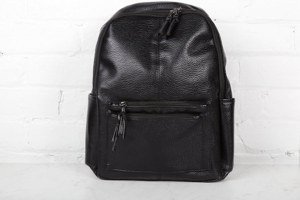

────────────────────────────────────────────────────────────────────────────────


,Category,ASIN,Title,Image
1,apparel,B01ESSA1BW,Heshe Women Leather Backpack Casual Daypack Sling Backpack Purse for Ladies and Girls,
2,apparel,B07RSVCJN5,Kattee Backpack Purse Leather Anti-theft Rucksack Shoulder Bag Travel Bag for Women Large Daypack,
3,apparel,B079DNGYCM,Backpack For Women Men Trendy PU Leather School College Bookbag USB Charging Port Laptop Computer Soft Leather Backpack Women Men Travel Backpack,
4,shoes,B07R2QJL7N,Vera Bradley Women's Cotton Xl Campus Backpack Bookbag,
5,apparel,B07V7DDDG9,YANAIER Women Mini Backpack Purse Waterproof Nylon Fashion College Bag Daypack,


Shopping assistant response:
 Here are my recommendations for the 5 search results in the context of a long trip:

1. This leather backpack seems like a good option for a long trip. The genuine leather material is durable and the large capacity provides enough space to pack essentials. The anti-theft design is great for travel security. 

2. This leather backpack from Kattee is also a nice choice for a long trip. The dual-way zippers allow convenient access to items. The shoulder straps are adjustable for comfort. The material is a mix of genuine and PU leather so it should hold up well.

3. [No recommendation provided since there is no information]

4. The Vera Bradley bags featured may not be the best for a long trip. These bags seem more suited for everyday or short trip use. The fabrics may not be as durable as leather for extended travel. 

5. This nylon backpack is lightweight and waterproof which are useful features for travel, but the capacity is quite small at just 11.5 x 10.3

In [ ]:
# Question 1 with text and image as inputs
query_text = "For a long trip."
query_image = "../images_retail/accessories/1.jpg"

img = Image.open(query_image) 
img = img.resize((300, 200))
print("Query text: "+query_text)
print("Query image:")
img.show()
print('─' * 80)

# Define the query and search body
with open(query_image, "rb") as image_file:
    query_image_binary = base64.b64encode(image_file.read()).decode("utf8")

response = aos_client.search(
    index='opensearch-rag-index',
    body={
        "_source": {
            "exclude": ["product_multimodal_vector", "product_title_vector"]
        },
        "query": {
            "neural": {
                "product_multimodal_vector": {
                    "query_image": query_image_binary,
                    "query_text": query_text,
                    "model_id": mm_embedding_model_id,
                    "k": 5
                }
            }
        },
        "collapse": {
            "field": "title.keyword"  #Collapse multiple results with the same title
        },
        "size": 5,
        "ext": {
            "generative_qa_parameters": {
                "llm_model": "bedrock/claude",
                "llm_question": query_text,
                "memory_id": memory_id,
                "context_size": 5,
                "message_size": 5,
                "timeout": 60
            }
        }
    },
    params={
        "search_pipeline": "multimodal_rag_pipeline"
    },
    request_timeout=300
)
# Format and display the query results
display_data = {
    'Category': [],
    'ASIN': [],
    'Title': [],
    'Image': []
}

# Refactor the response['hits'] into a dataframe for display
for item in response['hits']['hits']:
    display_data['Category'].append(item['_source']['template'])
    display_data['ASIN'].append(item['_source']['asin'])
    display_data['Title'].append(item['_source']['title'])
    display_data['Image'].append(item['_source']['image'])
    
df = pd.DataFrame(display_data)

df = df.reset_index(drop=True)
df.index += 1

def create_image_tag(path, width=100):
    return f'<img src="{path}" width="{width}">'

df['Image'] = df['Image'].apply(create_image_tag)

display(HTML(df.to_html(escape=False,index=True)))

print("\033[1mShopping assistant response:\033[0m")
print(response['ext']['retrieval_augmented_generation']['answer'])

## 5.3 Ask a follow-up question

In [ ]:
# Ask a follow up question

query_text = "Thanks. How about a bag for air travel?"

print("Input text query: " + query_text)
t.sleep(10)
# Perform the search (no new image this time)
response = aos_client.search(
    index='opensearch-rag-index',
    body={
        "_source": {
            "exclude": ["product_multimodal_vector", "product_title_vector"]
        },
        "query": {
            "neural": {
                "product_multimodal_vector": {
                    "query_text": query_text,
                    "model_id": mm_embedding_model_id,
                    "k": 5
                }
            }
        },
        "size": 5,
        "ext": {
            "generative_qa_parameters": {
                "llm_model": "bedrock/claude",
                "llm_question": query_text,
                "memory_id": memory_id,
                "context_size": 5,
                "message_size": 5,
                "timeout": 60
            }
        }
    },
    params={
        "search_pipeline": "multimodal_rag_pipeline"
    },
    request_timeout=300
)
# Format and display the query results
display_data = {
    'Category': [],
    'ASIN': [],
    'Title': [],
    'Image': []
}

# Refactor the response['hits'] into a dataframe for display
for item in response['hits']['hits']:
    display_data['Category'].append(item['_source']['template'])
    display_data['ASIN'].append(item['_source']['asin'])
    display_data['Title'].append(item['_source']['title'])
    display_data['Image'].append(item['_source']['image'])
    
df = pd.DataFrame(display_data)

df = df.reset_index(drop=True)
df.index += 1

def create_image_tag(path, width=100):
    return f'<img src="{path}" width="{width}">'

df['Image'] = df['Image'].apply(create_image_tag)

display(HTML(df.to_html(escape=False,index=True)))

print("\033[1mShopping assistant response:\033[0m")
print(response['ext']['retrieval_augmented_generation']['answer'])

## 5.4 Check the conversation history
To verify that the mmessages were added to the memory, provide the memory_ID to the Get Messages API:

In [ ]:
# Make the request
response = aos_client.transport.perform_request(
    'GET',
    "/_plugins/_ml/memory/"+memory_id +'/messages',
    headers={"Content-Type": "application/json"}
)
# Print the response. You should see a dictionary containing a list of messages.
#print(response) 
for message in response['messages']:
    print(message)

**You can experiment further** with different questions and follow-ups by re-running the '5.1 Create a new memory object' cell and then adjusting and re-running the cells below it. Further, you can go back to the pipeline creation cell (4.2) to experiment with different user instructions and system prompts.  

### Congratulations, at this point you have learned how to build conversational search with OpenSearch Service using the OpenSearch RAG processor.

# 6. Export objects for use in the web app

Now it's the time to experiment with agentic RAG with OpenSearch Service and Amazon Bedrock agents. To do so, run the following cell in step 6 and get back to the workshop to finish the part 2 agentic RAG of this lab.
The cell below will export a few environment variables for use in our application Lambda funcction. It will also set the 'AgentReady' flag to True in our DynamoDB table for this workshop.

In [ ]:
# update Lambda environment variables
lambda_client = boto3.client('lambda', region_name=region)

response = lambda_client.update_function_configuration(
    FunctionName= "shopping-assistant-function-" + account_id ,
    Environment={
        'Variables': {
            'DOMAIN_ENDPOINT': aos_host,
            'REGION': region,
            'TEXT_EMBEDDING_MODEL': text_embedding_model_id,
            'IMAGE_EMBEDDING_MODEL': mm_embedding_model_id,
            'INDEX_NAME': "opensearch-rag-index",
            'S3': account_id + "-ml-search"
        }
    }
)
if response['ResponseMetadata']['HTTPStatusCode'] == 200:
    ds.store_in_dynamo("AgentReady","True")
response['Environment']

# Now continue on to [Lab 5, Part 2: Agentic shopping assistant](https://catalog.workshops.aws/opensearch-ml-search/en-US/lab-5/agentic-rag).